In [3]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
from collections import defaultdict
import requests_cache
from fp.fp import FreeProxy
from retry_requests import retry
import openmeteo_requests
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tqdm

In [2]:
DATA_DIR = Path("data") 
REG_ELCTR_DIR = DATA_DIR / "region_electricity_data"
OUTPUT_FILE = DATA_DIR / "combined_region_electricity.csv"
OUTPUT_PREPARED_FILE = DATA_DIR / "ready2use_region_electricity.csv"
os.makedirs(DATA_DIR, exist_ok=True)

if OUTPUT_FILE.exists():
    print("Output file already exists. Exiting.")
    df = pd.read_csv(OUTPUT_FILE)
else:
    dfs = []

    for file in tqdm.tqdm(REG_ELCTR_DIR.iterdir()):
        if file.suffix in [".xls", ".xlsx"]:
            df = pd.read_excel(file)
            dfs.append(df)

    print(f"Loaded {len(dfs)} files")


Output file already exists. Exiting.


In [3]:
if not OUTPUT_FILE.exists():
    df = pd.concat(dfs, ignore_index=True)
    print("Merged shape:", df.shape)
    df.head(2)

In [4]:
if not OUTPUT_FILE.exists():
    KEEP_COLS = ['Region', 'UTC time','Demand','Net generation']

    to_drop = [c for c in df.columns if c not in KEEP_COLS]
    df = df.drop(columns=to_drop)
    df["UTC time"] = pd.to_datetime(df["UTC time"], utc=True, errors="coerce")
    df = df.rename(columns={"UTC time": "timestamp_utc"})
    df = df.sort_values(["Region", "timestamp_utc"]).reset_index(drop=True)
    df = df[df["timestamp_utc"] >= "2024-01-01"].copy()
    df = df[df["timestamp_utc"] <= "2025-01-01"].copy()
    print(df.isna().sum())
    print("Duplicates:", df.duplicated(["Region", "timestamp_utc"]).sum())
    print(df.head())

* **Region** - Код енергетичного регіону США (EIA balancing / monitoring region).
* **Demand** - Фактичне споживання електроенергії в регіоні у цей момент часу, MWh
* **Net generation** - Чиста генерація в регіоні: Net generation = local generation - internal consumption of power plants

In [5]:
if not OUTPUT_FILE.exists():
    print("Rows with NaNs (before imputation):")
    print(df[df[["Demand", "Net generation"]].isna().any(axis=1)].head(20))
    print("\nNaN counts before:")
    print(df[["Demand", "Net generation"]].isna().sum())
    # допоміжні колонки
    df["date"] = df["timestamp_utc"].dt.date
    # імпутація по (Region, date)
    for col in ["Demand", "Net generation"]:
        df[col] = df[col].fillna(
            df.groupby(["Region", "date"])[col].transform("median")
        )
    # fallback — по регіону
    for col in ["Demand", "Net generation"]:
        df[col] = df[col].fillna(
            df.groupby("Region")[col].transform("median")
        )
    # перевірка
    print(df[["Demand", "Net generation"]].isna().sum())
    df.to_csv(OUTPUT_FILE, index=False)
else:
    df = pd.read_csv(OUTPUT_FILE)

In [6]:
US_REGION_COORDS = {
    "TEX":  (31.0, -99.0),   # Texas
    "CAL":  (36.5, -119.5),  # California
    "MIDW": (41.8, -93.0),   # Midwest (Iowa-ish)

    "CENT": (39.0, -98.0),   # Central US (Kansas)
    "SE":   (33.0, -84.0),   # Southeast (Georgia)
    "SW":   (34.0, -111.0),  # Southwest (Arizona)
    "MIDA": (39.0, -77.0),   # Mid-Atlantic (Maryland)

    "NE":   (44.0, -71.5),   # New England
    "NY":   (43.0, -75.0),   # New York
    "NW":   (47.5, -120.5),  # Northwest (Washington)
    "TEN":  (35.8, -86.4),   # Tennessee
    "FLA":  (28.0, -82.0),   # Florida
    "CAR":  (35.5, -79.0),   # Carolinas
}

CACHE_FILE = DATA_DIR / "us_weather.cache_openmeteo"
US_WEATHER_CHECKPOINT = DATA_DIR / "us_weather_checkpoint.csv"

# ============================================================
# FAST PATH: if checkpoint exists > load and exit
# ============================================================
if US_WEATHER_CHECKPOINT.exists():
    print("[INFO] Weather checkpoint found, loading CSV.")
    us_weather_df = pd.read_csv(
        US_WEATHER_CHECKPOINT,
        parse_dates=["timestamp_utc"]
    ).sort_values(["us_region", "timestamp_utc"]).reset_index(drop=True)

    us_weather_df.head()
else:
    # ========================================================
    # Proxy generator
    # ========================================================
    def proxy_generator():
        while True:
            try:
                yield FreeProxy(rand=True, timeout=2).get()
            except Exception:
                time.sleep(1)

    proxy_pool = proxy_generator()

    # ========================================================
    # Open-Meteo client factory
    # ========================================================
    def get_openmeteo_client(proxy=None):
        session = requests_cache.CachedSession(CACHE_FILE, expire_after=-1)
        if proxy:
            session.proxies = {"http": proxy, "https": proxy}
        session = retry(session, retries=3, backoff_factor=0.3)
        return openmeteo_requests.Client(session=session)

    # ========================================================
    # Weather fetch (with proxy + fallback)
    # ========================================================
    def fetch_weather_hourly(lats, lons, start_date, end_date, max_attempts=10):
        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            "latitude": lats,
            "longitude": lons,
            "start_date": start_date,
            "end_date": end_date,
            "hourly": [
                "temperature_2m",
                "relative_humidity_2m",
                "precipitation",
                "snowfall",
                "cloud_cover",
                "wind_speed_10m",
                "wind_gusts_10m",
                "surface_pressure",
            ],
            "timezone": "UTC",
        }

        # --- try with proxies
        for _ in range(max_attempts):
            proxy = next(proxy_pool)
            try:
                client = get_openmeteo_client(proxy)
                return client.weather_api(url, params=params)
            except Exception:
                time.sleep(2)

        # --- fallback: direct (no proxy)
        try:
            print("[WARN] Proxy attempts failed, retrying without proxy")
            client = get_openmeteo_client(proxy=None)
            return client.weather_api(url, params=params)
        except Exception as e:
            raise RuntimeError(f"Weather fetch failed completely: {e}")

    # ========================================================
    # Time range
    # ========================================================
    START_DATE = "2022-01-01"
    END_DATE   = "2025-10-12"

    # ========================================================
    # Batch download
    # ========================================================
    weather_frames = []
    BATCH_SIZE = 4  # менше — стабільніше
    regions = list(US_REGION_COORDS.keys())

    for i in range(0, len(regions), BATCH_SIZE):
        batch = regions[i:i + BATCH_SIZE]
        lats, lons = zip(*(US_REGION_COORDS[r] for r in batch))

        print(f"[INFO] Fetching {batch}")

        responses = fetch_weather_hourly(
            list(lats), list(lons), START_DATE, END_DATE
        )

        for j, resp in enumerate(responses):
            region = batch[j]
            hourly = resp.Hourly()

            times = pd.date_range(
                start=pd.to_datetime(hourly.Time(), unit="s"),
                end=pd.to_datetime(hourly.TimeEnd(), unit="s"),
                freq="H",
                inclusive="left",
            )

            wdf = pd.DataFrame({
                "timestamp_utc": times,
                "us_region": region,
                "temperature": hourly.Variables(0).ValuesAsNumpy(),
                "humidity": hourly.Variables(1).ValuesAsNumpy(),
                "precipitation": hourly.Variables(2).ValuesAsNumpy(),
                "snowfall": hourly.Variables(3).ValuesAsNumpy(),
                "cloud_cover": hourly.Variables(4).ValuesAsNumpy(),
                "wind_speed": hourly.Variables(5).ValuesAsNumpy(),
                "wind_gusts": hourly.Variables(6).ValuesAsNumpy(),
                "surface_pressure": hourly.Variables(7).ValuesAsNumpy(),
            })

            weather_frames.append(wdf)

        time.sleep(2)

    # ========================================================
    # Final dataset + save
    # ========================================================
    us_weather_df = (
        pd.concat(weather_frames, ignore_index=True)
        .drop_duplicates(["timestamp_utc", "us_region"])
        .sort_values(["us_region", "timestamp_utc"])
        .reset_index(drop=True)
    )

    us_weather_df["timestamp_utc"] = pd.to_datetime(us_weather_df["timestamp_utc"],
                                                    utc=True,
                                                    errors="coerce")

    us_weather_df.to_csv(US_WEATHER_CHECKPOINT, index=False)
    print("[OK] Weather data downloaded and saved")

us_weather_df["timestamp_utc"] = pd.to_datetime(us_weather_df["timestamp_utc"],
                                                    utc=True,
                                                    errors="coerce")
us_weather_df.head()


[INFO] Weather checkpoint found, loading CSV.


,timestamp_utc,us_region,temperature,humidity,precipitation,snowfall,cloud_cover,wind_speed,wind_gusts,surface_pressure
0,2022-01-01 00:00:00+00:00,CAL,9.445499,59.914420,0.0,0.0,39.0,14.843180,29.880000,999.61030
1,2022-01-01 01:00:00+00:00,CAL,8.545500,61.649094,0.0,0.0,48.0,13.276144,28.080000,999.67346
2,2022-01-01 02:00:00+00:00,CAL,7.395500,71.081406,0.0,0.0,23.0,13.392774,24.480000,1000.31940
3,2022-01-01 03:00:00+00:00,CAL,6.895500,77.843540,0.0,0.0,27.0,11.966954,24.119999,1000.99146
4,2022-01-01 04:00:00+00:00,CAL,6.195500,80.536200,0.0,0.0,30.0,8.217153,21.599998,1001.35860


In [7]:
df["timestamp_utc"] = pd.to_datetime(df["timestamp_utc"],
                                     utc=True,
                                     errors="coerce")
df_us = df.merge(us_weather_df,
    left_on=["Region", "timestamp_utc"],
    right_on=["us_region", "timestamp_utc"],
    how="left"
)

df_us = df_us.drop(columns=["us_region"])
df_us.head()

,Region,timestamp_utc,Demand,Net generation,date,temperature,humidity,precipitation,snowfall,cloud_cover,wind_speed,wind_gusts,surface_pressure
0,CAL,2024-01-01 00:00:00+00:00,28114.0,22806.0,2024-01-01,12.995500,85.358520,0.0,0.0,100.0,2.741678,6.12,1007.46370
1,CAL,2024-01-01 01:00:00+00:00,28262.0,22782.0,2024-01-01,12.195499,76.033640,0.0,0.0,100.0,5.400000,5.76,1006.74005
2,CAL,2024-01-01 02:00:00+00:00,29413.0,23672.0,2024-01-01,10.445499,82.799510,0.0,0.0,98.0,6.120000,9.00,1006.37420
3,CAL,2024-01-01 03:00:00+00:00,31224.0,25599.0,2024-01-01,9.995500,84.457150,0.0,0.0,67.0,4.024922,9.72,1006.45540
4,CAL,2024-01-01 04:00:00+00:00,30872.0,24453.0,2024-01-01,9.295500,89.123924,0.0,0.0,83.0,12.261158,21.96,1006.82280


Мапимо цих 14 регіонів до наших 27, шляхом many-to-many, де один великий штат мапиться на декілька Укр. регіонів тощо:

In [8]:
CANONICAL_REGIONS = [ # P.S. розмічено чатом гпт =)
    # name, category, scale
    ("Вінницька",        "MID",   0.65),
    ("Волинська",        "SMALL", 0.35),
    ("Дніпропетровська", "BIG",   1.10),
    ("Донецька",         "BIG",   1.00),
    ("Житомирська",      "MID",   0.50),
    ("Закарпатська",     "SMALL", 0.30),
    ("Запорізька",       "BIG",   0.95),
    ("Івано-Франківська","SMALL", 0.35),
    ("Київська",         "BIG",   0.90),
    ("Кіровоградська",   "MID",   0.45),
    ("Луганська",        "MID",   0.40),
    ("Львівська",        "SMALL", 0.70),
    ("Миколаївська",     "MID",   0.60),
    ("Одеська",          "BIG",   1.00),
    ("Полтавська",       "MID",   0.70),
    ("Рівненська",       "SMALL", 0.35),
    ("Сумська",          "SMALL", 0.30),
    ("Тернопільська",    "SMALL", 0.30),
    ("Харківська",       "BIG",   1.05),
    ("Херсонська",       "MID",   0.45),
    ("Хмельницька",      "MID",   0.55),
    ("Черкаська",        "MID",   0.60),
    ("Чернівецька",      "SMALL", 0.25),
    ("Чернігівська",     "SMALL", 0.30),
    ("Київ",             "BIG",   1.20),
    ("м. Севастополь",   "SMALL", 0.15),
    ("АР Крим",          "SMALL", 0.20),
]


REGION_MAP = {
    "Дніпропетровська область": "Дніпропетровська",
    "Харківська область": "Харківська",
    "Полтавська область": "Полтавська",
    "Запорізька область": "Запорізька",
    "Сумська область": "Сумська",
    "Одеська область": "Одеська",
    "Кіровоградська область": "Кіровоградська",
    "Миколаївська область": "Миколаївська",
    "м. Київ": "Київ",
    "Черкаська область": "Черкаська",
    "Львівська область": "Львівська",
    "Хмельницька область": "Хмельницька",
    "Волинська область": "Волинська",
    "Івано-Франківська область": "Івано-Франківська",
    "Закарпатська область": "Закарпатська",
    "Рівненська область": "Рівненська",
    "Тернопільська область": "Тернопільська",
    "Чернівецька область": "Чернівецька",
    "Херсонська область": "Херсонська",
    "Вінницька область": "Вінницька",
    "Житомирська область": "Житомирська",
    "Київська область": "Київська",
    "Чернігівська область": "Чернігівська",
    "Луганська область": "Луганська",
    "Автономна Республіка Крим": "АР Крим",
    "м. Севастополь": "м. Севастополь",
}


In [9]:
UA_SCALE = {}
UA_CATEGORY = {}
UA_BY_CATEGORY = defaultdict(list)

for name, category, scale in CANONICAL_REGIONS:
    UA_SCALE[name] = scale
    UA_CATEGORY[name] = category
    UA_BY_CATEGORY[category].append(name)

US_GROUPS = {
    "BIG":   ["TEX", "CAL", "MIDW"],
    "MID":   ["CENT", "SE", "SW", "MIDA"],
    "SMALL": ["NE", "NY", "NW", "TEN", "FLA", "CAR"],
}

US_TO_UA_MAP = {
    us_region: UA_BY_CATEGORY[category]
    for category, us_regions in US_GROUPS.items()
    for us_region in us_regions
}


In [10]:
print(US_TO_UA_MAP["TEX"])
WEATHER_COLS = [
    "temperature",
    "humidity",
    "precipitation",
    "snowfall",
    "cloud_cover",
    "wind_speed",
    "wind_gusts",
    "surface_pressure",
]
#один рядок US - кілька рядків UA, але load масштабується по к-сть регіонів та UA_SCALE
def expand_us_to_ua(df):
    rows = []

    for _, r in df.iterrows():
        ua_regions = US_TO_UA_MAP[r["Region"]]
        base_share = 1.0 / len(ua_regions)

        for ua in ua_regions:
            scale = UA_SCALE[ua]

            row = {
                "timestamp_utc": r["timestamp_utc"],
                "us_region": r["Region"],
                "ua_region": ua,

                # load
                "demand_ua": r["Demand"] * base_share * scale,
                "generation_ua": r["Net generation"] * base_share * scale,
            }

            # weather (без масштабування)
            for c in WEATHER_COLS:
                row[c] = r[c]

            rows.append(row)

    return pd.DataFrame(rows)

ua_df = expand_us_to_ua(df_us)
ua_df = ua_df.sort_values(["ua_region", "timestamp_utc"]).reset_index(drop=True)
ua_df.head()

['Дніпропетровська', 'Донецька', 'Запорізька', 'Київська', 'Одеська', 'Харківська', 'Київ']


,timestamp_utc,us_region,ua_region,demand_ua,generation_ua,temperature,humidity,precipitation,snowfall,cloud_cover,wind_speed,wind_gusts,surface_pressure
0,2024-01-01 00:00:00+00:00,CAR,Івано-Франківська,847.350000,845.345455,5.7070,83.368645,0.0,0.0,1.0,11.681987,21.599998,1003.0945
1,2024-01-01 00:00:00+00:00,FLA,Івано-Франківська,866.122727,877.672727,12.2565,82.188960,0.0,0.0,12.0,7.754637,8.640000,1017.2195
2,2024-01-01 00:00:00+00:00,NE,Івано-Франківська,486.627273,431.422727,-7.7965,79.669960,0.0,0.0,98.0,7.289445,19.800000,931.7566
3,2024-01-01 00:00:00+00:00,NW,Івано-Франківська,1350.140909,1282.018182,1.6700,87.516464,0.0,0.0,17.0,4.553680,9.360000,961.2514
4,2024-01-01 00:00:00+00:00,NY,Івано-Франківська,590.800000,497.254545,-0.1635,77.269240,0.0,0.0,100.0,6.830519,14.400000,994.1605


Додаємо тривоги (+-15хв погодинне розбиття займає)

In [11]:
ALERTS_CSV = DATA_DIR / "alerts_merged_sorted.csv"
ALERTS_HOURLY_CSV = DATA_DIR / "alerts_hourly_merged_sorted.csv"

if ALERTS_HOURLY_CSV.exists():
    print("[INFO] Alerts hourly CSV found, loading.")
    alerts_hourly = pd.read_csv(
        ALERTS_HOURLY_CSV,
        parse_dates=["timestamp_utc"]
    ).sort_values(["ua_region", "timestamp_utc"]).reset_index(drop=True)
else:
    # ============================================================
    # Load alerts
    # ============================================================
    alerts_df = pd.read_csv(
        ALERTS_CSV,
        parse_dates=["Оголошено о", "Закінчено о"]
    )

    # ============================================================
    # Normalize timestamps (UTC)
    # ============================================================
    alerts_df["start_ts"] = pd.to_datetime(alerts_df["Оголошено о"], utc=True)
    alerts_df["end_ts"] = pd.to_datetime(
        alerts_df["Закінчено о"], utc=True, errors="coerce"
    )

    # fallback: якщо немає кінця + 1 година
    alerts_df["end_ts"] = alerts_df["end_ts"].fillna(
        alerts_df["start_ts"] + pd.Timedelta(hours=1)
    )

    # ============================================================
    # Damage flag
    # ============================================================
    alerts_df["isDamaged"] = (
        alerts_df["Повідомлення"].notna() &
        (alerts_df["Повідомлення"].astype(str).str.strip() != "")
    )

    # ============================================================
    # Normalize regions → canonical UA
    # ============================================================
    alerts_df["ua_region"] = alerts_df["Регіон"].map(REGION_MAP)

    CANONICAL_REGION_NAMES = {name for name, _, _ in CANONICAL_REGIONS}
    alerts_df = alerts_df[alerts_df["ua_region"].isin(CANONICAL_REGION_NAMES)]

    # ============================================================
    # global hourly grid
    # ============================================================
    GLOBAL_START = alerts_df["start_ts"].min().floor("h")
    GLOBAL_END   = alerts_df["end_ts"].max().ceil("h")

    ALL_HOURS = pd.date_range(
        start=GLOBAL_START,
        end=GLOBAL_END,
        freq="h",
        inclusive="left"
    )

    # ============================================================
    # Expand alerts into hourly
    # ============================================================
    alert_rows = []

    for _, r in alerts_df.iterrows():
        start = r["start_ts"].floor("h")
        end   = r["end_ts"].ceil("h")

        hours = pd.date_range(
            start=start,
            end=end,
            freq="h",
            inclusive="left"
        )

        for ts in hours:
            alert_rows.append({
                "timestamp_utc": ts,
                "ua_region": r["ua_region"],
                "alert_active": 1,
                "isDamaged": r["isDamaged"],
            })

    alerts_active = pd.DataFrame(alert_rows)

    # ============================================================
    # Aggregate overlaps
    # ============================================================
    alerts_active = (
        alerts_active
        .groupby(["timestamp_utc", "ua_region"], as_index=False)
        .agg(
            alert_active=("alert_active", "max"),
            isDamaged=("isDamaged", "any"),
        )
    )

    # ============================================================
    # FULL hourly grid: region x hour 
    # ============================================================
    full_index = pd.MultiIndex.from_product(
        [CANONICAL_REGION_NAMES, ALL_HOURS],
        names=["ua_region", "timestamp_utc"]
    )

    alerts_hourly = (
        pd.DataFrame(index=full_index)
        .reset_index()
        .merge(
            alerts_active,
            on=["ua_region", "timestamp_utc"],
            how="left"
        )
    )

    # ============================================================
    # Fill NO-ALERT hours with zeros
    # ============================================================
    alerts_hourly["alert_active"] = alerts_hourly["alert_active"].fillna(0).astype(int)
    alerts_hourly["isDamaged"] = alerts_hourly["isDamaged"].fillna(False)

    # ============================================================
    # Final sanity
    # ============================================================
    alerts_hourly = alerts_hourly.sort_values(
        ["ua_region", "timestamp_utc"]
    ).reset_index(drop=True)

    alerts_hourly.to_csv(ALERTS_HOURLY_CSV, index=False)
    
alerts_hourly.head(10)


[INFO] Alerts hourly CSV found, loading.


,ua_region,timestamp_utc,alert_active,isDamaged
0,Івано-Франківська,2022-05-01 05:00:00+00:00,0,False
1,Івано-Франківська,2022-05-01 06:00:00+00:00,0,False
2,Івано-Франківська,2022-05-01 07:00:00+00:00,0,False
3,Івано-Франківська,2022-05-01 08:00:00+00:00,0,False
4,Івано-Франківська,2022-05-01 09:00:00+00:00,0,False
5,Івано-Франківська,2022-05-01 10:00:00+00:00,0,False
6,Івано-Франківська,2022-05-01 11:00:00+00:00,0,False
7,Івано-Франківська,2022-05-01 12:00:00+00:00,0,False
8,Івано-Франківська,2022-05-01 13:00:00+00:00,0,False
9,Івано-Франківська,2022-05-01 14:00:00+00:00,0,False


накладаємо тривоги на всі регіони та дати

In [12]:
ua_df["timestamp_utc"] = pd.to_datetime(ua_df["timestamp_utc"], utc=True)
alerts_hourly["timestamp_utc"] = pd.to_datetime(alerts_hourly["timestamp_utc"], utc=True)
ua_df_merged = (ua_df.merge(alerts_hourly, on=["ua_region", "timestamp_utc"], how="left"))
ua_df_merged["alert_active"] = (ua_df_merged["alert_active"].fillna(0).astype(int))
ua_df_merged["isDamaged"] = (ua_df_merged["isDamaged"].fillna(False))
ua_df_merged.head()


,timestamp_utc,us_region,ua_region,demand_ua,generation_ua,temperature,humidity,precipitation,snowfall,cloud_cover,wind_speed,wind_gusts,surface_pressure,alert_active,isDamaged
0,2024-01-01 00:00:00+00:00,CAR,Івано-Франківська,847.350000,845.345455,5.7070,83.368645,0.0,0.0,1.0,11.681987,21.599998,1003.0945,0,False
1,2024-01-01 00:00:00+00:00,FLA,Івано-Франківська,866.122727,877.672727,12.2565,82.188960,0.0,0.0,12.0,7.754637,8.640000,1017.2195,0,False
2,2024-01-01 00:00:00+00:00,NE,Івано-Франківська,486.627273,431.422727,-7.7965,79.669960,0.0,0.0,98.0,7.289445,19.800000,931.7566,0,False
3,2024-01-01 00:00:00+00:00,NW,Івано-Франківська,1350.140909,1282.018182,1.6700,87.516464,0.0,0.0,17.0,4.553680,9.360000,961.2514,0,False
4,2024-01-01 00:00:00+00:00,NY,Івано-Франківська,590.800000,497.254545,-0.1635,77.269240,0.0,0.0,100.0,6.830519,14.400000,994.1605,0,False


In [13]:
t1 = ua_df_merged[ua_df_merged['isDamaged']==True].head()
t1[['ua_region', 'demand_ua', 'generation_ua', 'temperature', 'humidity', 'precipitation', 'snowfall', 'cloud_cover', 'wind_speed', 'wind_gusts', 'surface_pressure', 'alert_active', 'isDamaged']]

,ua_region,demand_ua,generation_ua,temperature,humidity,precipitation,snowfall,cloud_cover,wind_speed,wind_gusts,surface_pressure,alert_active,isDamaged
1776,Івано-Франківська,638.368182,651.572727,13.157001,80.938630,0.0,0.00,100.0,21.578989,41.039997,983.50450,1,True
1777,Івано-Франківська,629.968182,638.845455,20.706501,94.297844,0.6,0.00,100.0,15.986593,38.160000,1004.06690,1,True
1778,Івано-Франківська,354.677273,281.240909,-4.196500,97.036190,0.2,0.14,100.0,24.840000,65.880000,929.33140,1,True
1779,Івано-Франківська,1629.663636,1451.800000,-31.029999,67.470270,0.0,0.00,40.0,7.145796,13.679999,965.68744,1,True
1780,Івано-Франківська,454.809091,402.500000,2.286500,95.809456,2.4,1.47,100.0,27.887802,62.279995,976.24640,1,True


In [14]:
print("Total rows:", len(ua_df_merged))

print("\nAlert distribution:")
print(ua_df_merged["alert_active"].value_counts())

print("\nDamage distribution:")
print(ua_df_merged["isDamaged"].value_counts())

invalid = ua_df_merged.query("isDamaged == True and alert_active == 0")
print("\nInvalid damage rows:", len(invalid))


Total rows: 1080555

Alert distribution:
alert_active
1    976141
0    104414
Name: count, dtype: int64

Damage distribution:
isDamaged
True     609693
False    470862
Name: count, dtype: int64

Invalid damage rows: 0


Тривог по регіонам:

In [15]:
alerts_by_region = (
    ua_df_merged
    .groupby("ua_region")["alert_active"]
    .sum()
    .rename("alert_hours")
    .sort_values(ascending=False)
)

alerts_by_region.head(10)

ua_region
Сумська              50718
Чернігівська         50484
Рівненська           49464
Тернопільська        49410
Львівська            49224
Івано-Франківська    49218
Чернівецька          49212
Волинська            49206
Закарпатська         49194
АР Крим              47436
Name: alert_hours, dtype: int64

Пошкоджень по регіонам

In [16]:
damage_by_region = (
    ua_df_merged
    .groupby("ua_region")["isDamaged"]
    .sum()
    .rename("damage_hours")
    .sort_values(ascending=False)
)

damage_by_region.head(10)

ua_region
Сумська           49824
АР Крим           47436
м. Севастополь    47214
Львівська         39054
Херсонська        33476
Полтавська        32820
Хмельницька       32688
Кіровоградська    32200
Вінницька         28624
Миколаївська      26564
Name: damage_hours, dtype: int64

Пошкодження коли були тривоги

In [17]:
p_damage_given_alert = (
    ua_df_merged
    .query("alert_active == 1")
    .groupby("ua_region")["isDamaged"]
    .mean()
    .rename("P(damage | alert)")
    .sort_values(ascending=False)
)

p_damage_given_alert.head(15)

ua_region
АР Крим             1.000000
Луганська           1.000000
м. Севастополь      1.000000
Херсонська          0.991470
Хмельницька         0.987672
Сумська             0.982373
Запорізька          0.981273
Одеська             0.975288
Полтавська          0.975276
Київ                0.973549
Дніпропетровська    0.958968
Київська            0.955497
Кіровоградська      0.951312
Харківська          0.950091
Вінницька           0.860717
Name: P(damage | alert), dtype: float64

Дифіцити енергії

In [18]:
ua_df_merged["supply_ok"] = ua_df_merged["generation_ua"] >= ua_df_merged["demand_ua"]
total_rows = len(ua_df_merged)
ok_rows = ua_df_merged["supply_ok"].sum()
bad_rows = total_rows - ok_rows

print(f"Total rows: {total_rows:,}")
print(f"Supply OK: {ok_rows:,} ({ok_rows/total_rows:.2%})")
print(f"Supply deficit: {bad_rows:,} ({bad_rows/total_rows:.2%})")


Total rows: 1,080,555
Supply OK: 480,812 (44.50%)
Supply deficit: 599,743 (55.50%)


In [19]:
ua_df_merged["energy_deficit"] = (ua_df_merged["demand_ua"] - ua_df_merged["generation_ua"])
ua_df_merged.head()

,timestamp_utc,us_region,ua_region,demand_ua,generation_ua,temperature,humidity,precipitation,snowfall,cloud_cover,wind_speed,wind_gusts,surface_pressure,alert_active,isDamaged,supply_ok,energy_deficit
0,2024-01-01 00:00:00+00:00,CAR,Івано-Франківська,847.350000,845.345455,5.7070,83.368645,0.0,0.0,1.0,11.681987,21.599998,1003.0945,0,False,False,2.004545
1,2024-01-01 00:00:00+00:00,FLA,Івано-Франківська,866.122727,877.672727,12.2565,82.188960,0.0,0.0,12.0,7.754637,8.640000,1017.2195,0,False,True,-11.550000
2,2024-01-01 00:00:00+00:00,NE,Івано-Франківська,486.627273,431.422727,-7.7965,79.669960,0.0,0.0,98.0,7.289445,19.800000,931.7566,0,False,False,55.204545
3,2024-01-01 00:00:00+00:00,NW,Івано-Франківська,1350.140909,1282.018182,1.6700,87.516464,0.0,0.0,17.0,4.553680,9.360000,961.2514,0,False,False,68.122727
4,2024-01-01 00:00:00+00:00,NY,Івано-Франківська,590.800000,497.254545,-0.1635,77.269240,0.0,0.0,100.0,6.830519,14.400000,994.1605,0,False,False,93.545455


Після накладання тривог потрібно логічним чином зімітувати їх вплив на на систему:

In [20]:
ALERT_GEN_DERATE = 0.01 # припустимо втрати генерації під час тривоги = 1%
ALERT_DEMAND_NOISE = 0.05 # +/- 5% шум попиту під час тривоги

DAMAGE_GEN_DERATE_MIN = 0.20 # мінімальна втрата при пошкодженні
DAMAGE_GEN_DERATE_MAX = 0.45 # максимальна
DAMAGE_TAU_RECOVERY = 24 # годин на відновлення

In [21]:
# попит стає менш передбачуваним під час тривоги
rng = np.random.default_rng(42)
ua_df_merged["demand_ua_adj"] = ua_df_merged["demand_ua"]

alert_mask = ua_df_merged["alert_active"] == 1

ua_df_merged.loc[alert_mask, "demand_ua_adj"] *= (
    1.0 + rng.normal(loc=0.0, scale=ALERT_DEMAND_NOISE, size=alert_mask.sum())
)

ua_df_merged["generation_ua_adj"] = ua_df_merged["generation_ua"]
ua_df_merged.loc[alert_mask, "generation_ua_adj"] *= (1.0 - ALERT_GEN_DERATE)


In [22]:
# damage_event = True -> початок деградації
ua_df_merged["damage_event"] = ((ua_df_merged["isDamaged"] == True) &
    (ua_df_merged.groupby("ua_region")["isDamaged"].shift(1) == False)
)
ua_df_merged["damage_derate"] = 0.0
for region, g in ua_df_merged.groupby("ua_region"):
    idx = g.index
    damage_start_times = g.loc[g["damage_event"], "timestamp_utc"]

    for t0 in damage_start_times:
        mask = (
            (ua_df_merged["ua_region"] == region) &
            (ua_df_merged["timestamp_utc"] >= t0))

        dt = (ua_df_merged.loc[mask, "timestamp_utc"] - t0).dt.total_seconds() / 3600.0

        severity = rng.uniform(DAMAGE_GEN_DERATE_MIN,
                               DAMAGE_GEN_DERATE_MAX)

        ua_df_merged.loc[mask, "damage_derate"] += (
            severity * np.exp(-dt / DAMAGE_TAU_RECOVERY)) # експоненціальне відновлення

ua_df_merged["generation_ua_adj"] = ua_df_merged["generation_ua"]

ua_df_merged["generation_ua_adj"] *= (1.0 - ua_df_merged["damage_derate"].clip(upper=0.9))
# генерація падає різко, відновлюється поступово


In [23]:
ua_df_merged["energy_deficit_adj"] = (
    ua_df_merged["demand_ua_adj"] -
    ua_df_merged["generation_ua_adj"]
).clip(lower=0)

ua_df_merged["supply_ok_adj"] = (
    ua_df_merged["generation_ua_adj"] >=
    ua_df_merged["demand_ua_adj"]
)

HORIZON = 6
FUTURE_FEATURES = [
    "alert_active",
    "isDamaged",
    "temperature",
    "wind_speed",
    "cloud_cover",
]
for h in range(1, HORIZON + 1):
    for col in FUTURE_FEATURES:
        ua_df_merged[f"{col}_f{h}"] = (
            ua_df_merged
            .groupby("ua_region")[col]
            .shift(-h)
        )
ua_df_merged = ua_df_merged.dropna().reset_index(drop=True)


ua_df_merged.to_csv(OUTPUT_PREPARED_FILE, index=False)
ua_df_merged.tail(3)

,timestamp_utc,us_region,ua_region,demand_ua,generation_ua,temperature,humidity,precipitation,snowfall,cloud_cover,...,alert_active_f5,isDamaged_f5,temperature_f5,wind_speed_f5,cloud_cover_f5,alert_active_f6,isDamaged_f6,temperature_f6,wind_speed_f6,cloud_cover_f6
1080390,2024-12-31 23:00:00+00:00,NW,м. Севастополь,621.600000,607.690909,-1.880000,90.82195,0.0,0.0,100.0,...,0.0,False,-3.6465,3.415260,42.0,0.0,False,-2.2300,2.012461,100.0
1080391,2024-12-31 23:00:00+00:00,NY,м. Севастополь,257.236364,229.022727,3.536500,81.02966,0.0,0.0,100.0,...,0.0,False,-2.2300,2.012461,100.0,0.0,False,2.5865,14.650938,100.0
1080392,2024-12-31 23:00:00+00:00,TEN,м. Севастополь,246.668182,248.372727,8.537001,63.43470,0.0,0.0,96.0,...,0.0,False,2.5865,14.650938,100.0,0.0,False,7.9370,18.030573,100.0


Selected main damage event: 2024-12-19 01:00:00+00:00


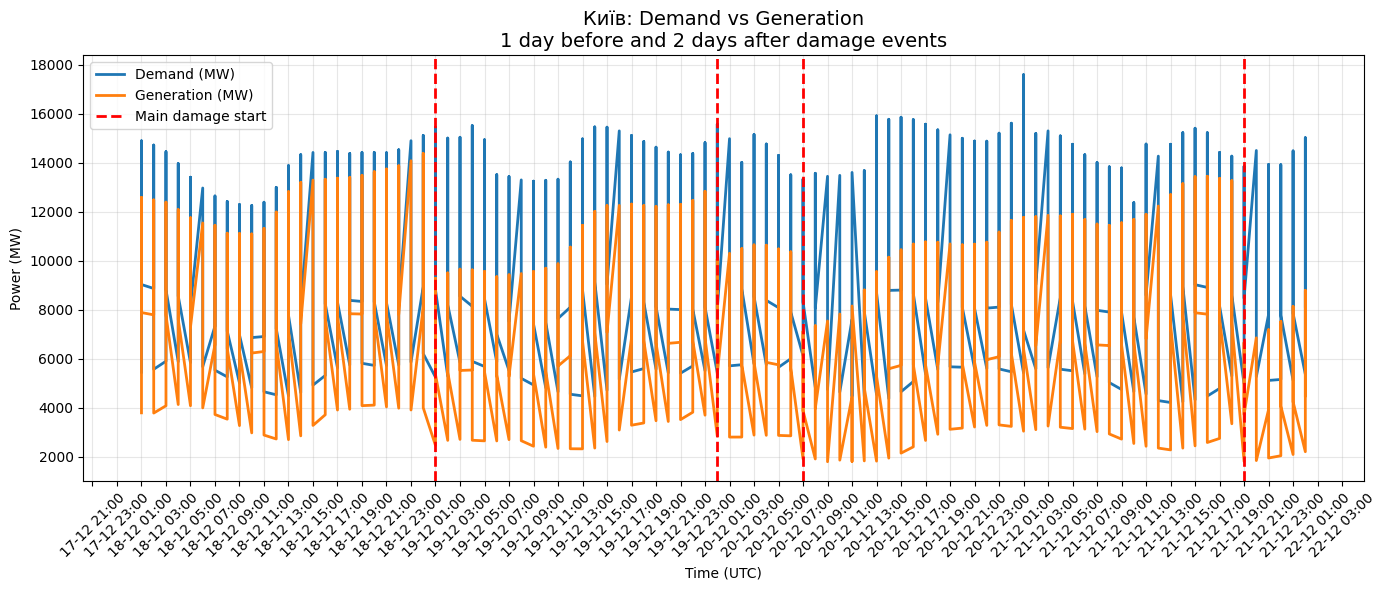

In [24]:

REGION = "Київ"

dk_all = (
    ua_df_merged
    .query("ua_region == @REGION")
    .sort_values("timestamp_utc")
    .reset_index(drop=True)
)

# --- визначаємо початок кожного пошкодження ---
dk_all["damage_event"] = (
    dk_all["isDamaged"] &
    (~dk_all["isDamaged"].shift(1, fill_value=False))
)

DATA_START = dk_all["timestamp_utc"].min()
DATA_END   = dk_all["timestamp_utc"].max()

VALID_EVENTS = dk_all.loc[
    dk_all["damage_event"] &
    (dk_all["timestamp_utc"] > DATA_START + pd.Timedelta(days=1)) &
    (dk_all["timestamp_utc"] < DATA_END   - pd.Timedelta(days=2)),
    "timestamp_utc"
]

if len(VALID_EVENTS) == 0:
    raise RuntimeError("No valid damage events with sufficient history")

# --- беремо репрезентативну (не першу) ---
damage_ts = VALID_EVENTS.iloc[len(VALID_EVENTS) // 2]
print("Selected main damage event:", damage_ts)

# --- часовий інтервал ---
start = damage_ts - pd.Timedelta(days=1)
end   = damage_ts + pd.Timedelta(days=3)

dk = dk_all[
    (dk_all["timestamp_utc"] >= start) &
    (dk_all["timestamp_utc"] < end)
]

# --- всі damage_event у цьому вікні ---
window_damage_events = dk.loc[dk["damage_event"], "timestamp_utc"]

# ===============================
# PLOT
# ===============================
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(
    dk["timestamp_utc"],
    dk["demand_ua_adj"],
    label="Demand (MW)",
    linewidth=2
)

ax.plot(
    dk["timestamp_utc"],
    dk["generation_ua_adj"],
    label="Generation (MW)",
    linewidth=2
)

# --- основний damage event ---
ax.axvline(
    damage_ts,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Main damage start"
)

# --- інші damage events у вікні ---
for ts in window_damage_events:
    if ts == damage_ts:
        continue 
    ax.axvline(
        ts,
        color="red",
        linestyle="--",
        linewidth=2,
    )

ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m %H:%M"))

ax.set_title(
    f"{REGION}: Demand vs Generation\n"
    "1 day before and 2 days after damage events",
    fontsize=14
)

ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Power (MW)")
ax.grid(True, alpha=0.3)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Як можна побачити попит почав змінюватися після дамагу, генерація сильно змінюватися, але із поступовим відновленням протягом 36 годин. Аналогічна картина із дефіцитом

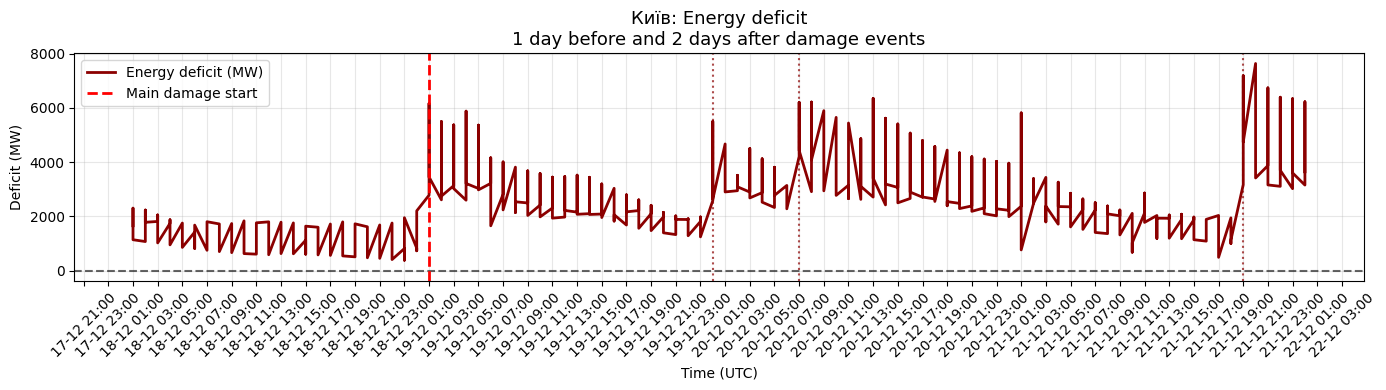

In [25]:
plt.figure(figsize=(14, 4))

plt.plot(
    dk["timestamp_utc"],
    dk["energy_deficit_adj"],
    color="darkred",
    linewidth=2,
    label="Energy deficit (MW)"
)

# нульова лінія
plt.axhline(
    0,
    linestyle="--",
    color="black",
    alpha=0.6
)

# --- основний damage event ---
plt.axvline(
    damage_ts,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Main damage start"
)

# --- інші damage events у цьому ж вікні ---
for ts in window_damage_events:
    if ts == damage_ts:
        continue
    plt.axvline(
        ts,
        color="darkred",
        linestyle=":",
        linewidth=1.5,
        alpha=0.7
    )

plt.title(
    f"{REGION}: Energy deficit\n"
    "1 day before and 2 days after damage events",
    fontsize=13
)

plt.xlabel("Time (UTC)")
plt.ylabel("Deficit (MW)")
plt.grid(alpha=0.3)

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d-%m %H:%M"))
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()


Погода показує логічні зміни в попиті

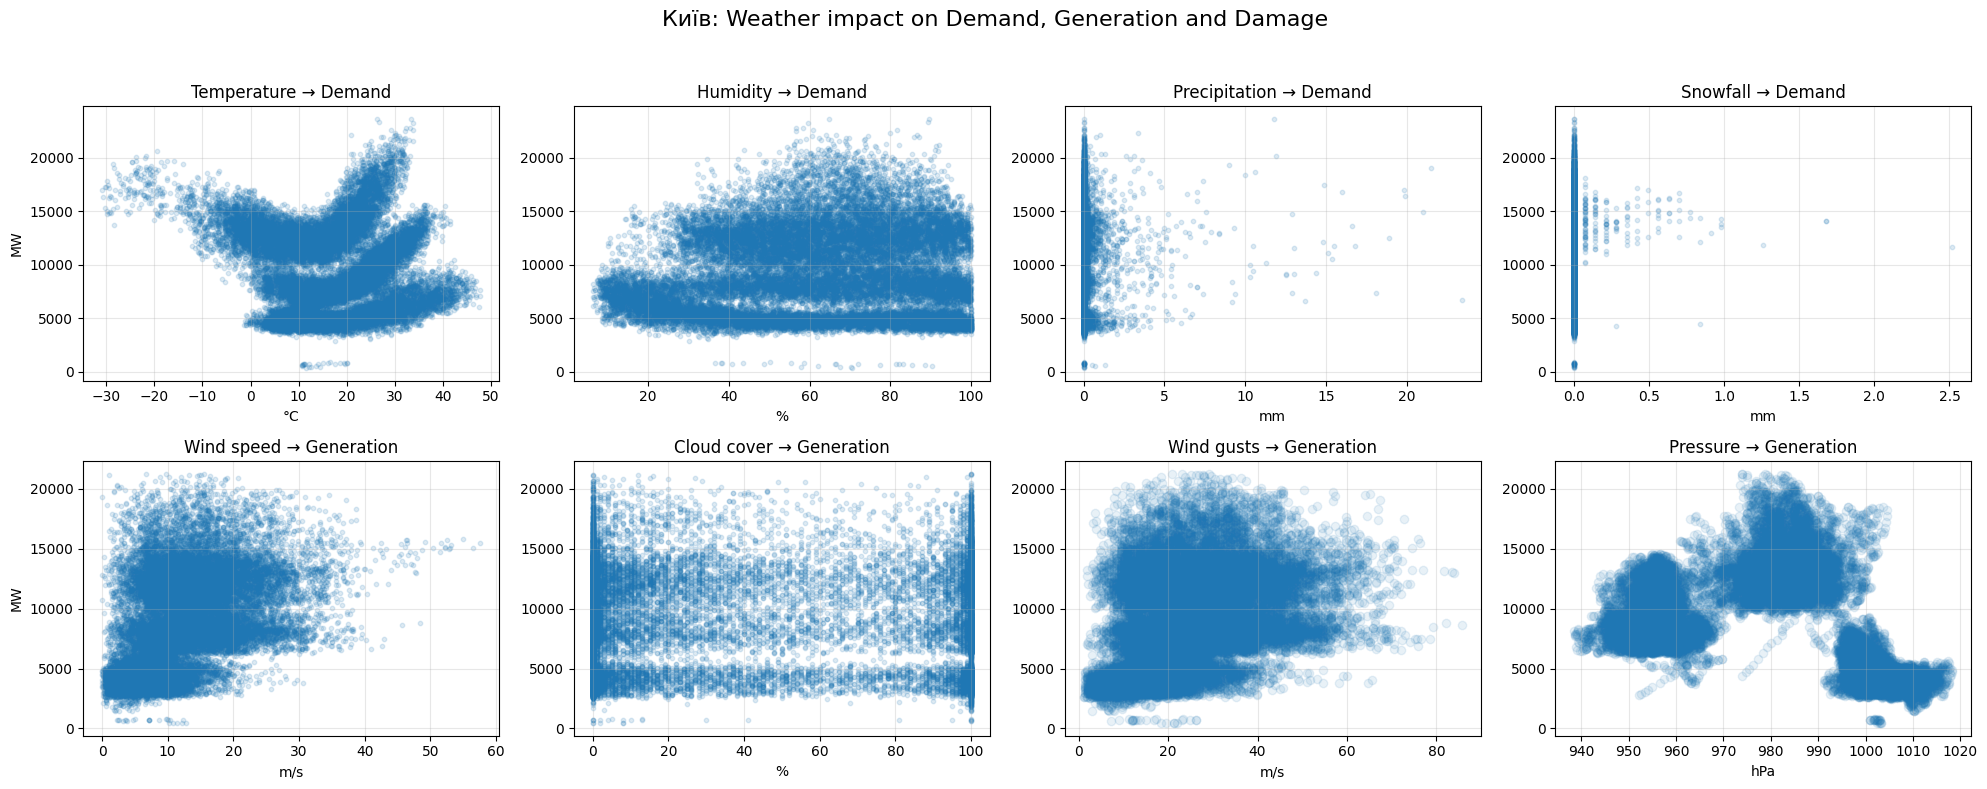

In [26]:
REGION = "Київ"
df = ua_df_merged.query("ua_region == @REGION").copy()

fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharey=False)
fig.suptitle(f"{REGION}: Weather impact on Demand, Generation and Damage", fontsize=16)

# -------------------------
# Row 1 — Demand
# -------------------------
axes[0, 0].scatter(df["temperature"], df["demand_ua_adj"], alpha=0.15, s=10)
axes[0, 0].set_title("Temperature → Demand")
axes[0, 0].set_xlabel("°C")
axes[0, 0].set_ylabel("MW")

axes[0, 1].scatter(df["humidity"], df["demand_ua_adj"], alpha=0.15, s=10)
axes[0, 1].set_title("Humidity → Demand")
axes[0, 1].set_xlabel("%")

axes[0, 2].scatter(df["precipitation"], df["demand_ua_adj"], alpha=0.15, s=10)
axes[0, 2].set_title("Precipitation → Demand")
axes[0, 2].set_xlabel("mm")

axes[0, 3].scatter(df["snowfall"], df["demand_ua_adj"], alpha=0.15, s=10)
axes[0, 3].set_title("Snowfall → Demand")
axes[0, 3].set_xlabel("mm")

# -------------------------
# Row 2 — Generation
# -------------------------
axes[1, 0].scatter(df["wind_speed"], df["generation_ua_adj"], alpha=0.15, s=10)
axes[1, 0].set_title("Wind speed → Generation")
axes[1, 0].set_xlabel("m/s")
axes[1, 0].set_ylabel("MW")

axes[1, 1].scatter(df["cloud_cover"], df["generation_ua_adj"], alpha=0.15, s=10)
axes[1, 1].set_title("Cloud cover → Generation")
axes[1, 1].set_xlabel("%")

axes[1, 2].scatter(df["wind_gusts"], df["generation_ua_adj"].astype(int), alpha=0.1)
axes[1, 2].set_title("Wind gusts → Generation")
axes[1, 2].set_xlabel("m/s")

axes[1, 3].scatter(df["surface_pressure"], df["generation_ua_adj"].astype(int), alpha=0.1)
axes[1, 3].set_title("Pressure → Generation")
axes[1, 3].set_xlabel("hPa")

for ax in axes.flat:
    ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
